<h1 align="center">🎾 - Tennis Betting 👨‍💻🔬</h1>

<h2 align="center">EDA</h2>
<p style="text-align:center">
   Thomas Bury & Vilius Jaseliunas<br>
   Allianz<br>
</p>

# Database

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from arfs.feature_selection import (
    Leshy,
    MissingValueThreshold,
    UniqueValuesThreshold,
    make_fs_summary,
)

data = pd.read_csv("../data/atp_data.csv", low_memory=False)
data["Date"] = pd.to_datetime(data["Date"])
data.sort_values("Date")
data.head()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Kiefer N.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Gaudio G.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,El Aynaoui Y.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Cherkasov A.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5


In [2]:
data.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'Wsets',
       'Lsets', 'Comment', 'PSW', 'PSL', 'B365W', 'B365L', 'elo_winner',
       'elo_loser', 'proba_elo'],
      dtype='object')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44708 entries, 0 to 44707
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         44708 non-null  int64         
 1   Location    44708 non-null  object        
 2   Tournament  44708 non-null  object        
 3   Date        44708 non-null  datetime64[ns]
 4   Series      44708 non-null  object        
 5   Court       44708 non-null  object        
 6   Surface     44708 non-null  object        
 7   Round       44708 non-null  object        
 8   Best of     44708 non-null  int64         
 9   Winner      44708 non-null  object        
 10  Loser       44708 non-null  object        
 11  WRank       44708 non-null  int64         
 12  LRank       44708 non-null  int64         
 13  Wsets       44521 non-null  float64       
 14  Lsets       44521 non-null  float64       
 15  Comment     44708 non-null  object        
 16  PSW         32743 non-

Is the best ranked player the winner?

In [4]:
100 * (data["WRank"] < data["LRank"]).sum() / len(data)

65.60570815066654

we need to drop the number of sets won since it identifies almost 100% of the winner.

In [5]:
100 * (data["Wsets"] > data["Lsets"]).sum() / len(data)

98.21284781247203

# Renaming columns

To avoid obvious data leakage, rename the columns by replacing the W by P1 and L by P2. Then permute P1 and P2 1 every two rows (preventing the winner to be always P1).

**REM:** 

 - need to drop the number of sets won
 - need to compute the complementary elo probability since there is a single elo probability column, corresponding to the winning probability of the player who effectively won the game.

In [6]:
df = data.copy()
df.columns = df.columns.str.lower()
df.rename(
    columns={
        "wrank": "rank_p1",
        "lrank": "rank_p2",
        "wsets": "sets_p1",
        "lsets": "sets_p2",
        "psw": "ps_p1",
        "psl": "ps_p2",
        "b365w": "b365_p1",
        "b365l": "b365_p2",
    },
    inplace=True,
)
df.columns = df.columns.str.lower()
df.rename(
    columns=lambda x: x.replace("winner", "p1").replace("loser", "p2"), inplace=True
)
# Print the modified column names
print(df.columns)

Index(['atp', 'location', 'tournament', 'date', 'series', 'court', 'surface',
       'round', 'best of', 'p1', 'p2', 'rank_p1', 'rank_p2', 'sets_p1',
       'sets_p2', 'comment', 'ps_p1', 'ps_p2', 'b365_p1', 'b365_p2', 'elo_p1',
       'elo_p2', 'proba_elo'],
      dtype='object')


In [7]:
df[["p1", "p2"]]

,p1,p2
0,Dosedel S.,Ljubicic I.
1,Kiefer N.,Tarango J.
2,Gaudio G.,Luxa P.
3,El Aynaoui Y.,Dupuis A.
4,Cherkasov A.,Arazi H.
...,...,...
44703,Bautista Agut R.,Pouille L.
44704,Anderson K.,Donaldson J.
44705,Jarry N.,Zeballos H.
44706,Del Potro J.M.,Anderson K.


In [8]:
p1_columns = df.filter(like="p1").columns
p2_columns = df.filter(like="p2").columns

print("Columns containing P1:")
print(p1_columns)

print("Columns containing P2:")
print(p2_columns)

Columns containing P1:
Index(['p1', 'rank_p1', 'sets_p1', 'ps_p1', 'b365_p1', 'elo_p1'], dtype='object')
Columns containing P2:
Index(['p2', 'rank_p2', 'sets_p2', 'ps_p2', 'b365_p2', 'elo_p2'], dtype='object')


# Shuffling players info

In [9]:
df_permuted = df.copy()
# swap the values P1 <-> P2 every two rows
mask = df.index % 2 == 1
df_permuted.loc[mask, p1_columns], df_permuted.loc[mask, p2_columns] = (
    df.loc[mask, p2_columns].values,
    df.loc[mask, p1_columns].values,
)

# the complementary prob for the swapped rows
# ELO proba (e.g. definition: https://ideas.repec.org/p/nbs/wpaper/2019-03.html#:~:text=The%20Elo%20rating%20system%20is,accuracy%2C%20calibration%20and%20model%20discrimination.)
df_permuted.loc[mask, "proba_elo"] = 1 - df_permuted.loc[mask, "proba_elo"].values

# does player 1 win?
df_permuted["target"] = "p1"
df_permuted.loc[mask, "target"] = "p2"
df_permuted.head()

,atp,location,tournament,date,series,court,surface,round,best of,p1,...,sets_p2,comment,ps_p1,ps_p2,b365_p1,b365_p2,elo_p1,elo_p2,proba_elo,target
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5,p1
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Tarango J.,...,2.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5,p2
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Gaudio G.,...,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5,p1
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Dupuis A.,...,2.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5,p2
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Cherkasov A.,...,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5,p1


In [10]:
df_permuted.iloc[:, :15].head()

,atp,location,tournament,date,series,court,surface,round,best of,p1,p2,rank_p1,rank_p2,sets_p1,sets_p2
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,63,77,2.0,0.0
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Tarango J.,Kiefer N.,59,6,0.0,2.0
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Gaudio G.,Luxa P.,73,174,2.0,1.0
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Dupuis A.,El Aynaoui Y.,78,33,1.0,2.0
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Cherkasov A.,Arazi H.,206,35,2.0,0.0


In [11]:
data.iloc[:, :15].head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Wsets,Lsets
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,63,77,2.0,0.0
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Kiefer N.,Tarango J.,6,59,2.0,0.0
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Gaudio G.,Luxa P.,73,174,2.0,1.0
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,El Aynaoui Y.,Dupuis A.,33,78,2.0,1.0
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Cherkasov A.,Arazi H.,206,35,2.0,0.0


In [12]:
p2_columns

Index(['p2', 'rank_p2', 'sets_p2', 'ps_p2', 'b365_p2', 'elo_p2'], dtype='object')

In [13]:
player_columns = sorted(list(set(p1_columns).union(set(p2_columns))))
df[player_columns].head()

,b365_p1,b365_p2,elo_p1,elo_p2,p1,p2,ps_p1,ps_p2,rank_p1,rank_p2,sets_p1,sets_p2
0,NaN,NaN,1500.0,1500.0,Dosedel S.,Ljubicic I.,NaN,NaN,63,77,2.0,0.0
1,NaN,NaN,1500.0,1500.0,Kiefer N.,Tarango J.,NaN,NaN,6,59,2.0,0.0
2,NaN,NaN,1500.0,1500.0,Gaudio G.,Luxa P.,NaN,NaN,73,174,2.0,1.0
3,NaN,NaN,1500.0,1500.0,El Aynaoui Y.,Dupuis A.,NaN,NaN,33,78,2.0,1.0
4,NaN,NaN,1500.0,1500.0,Cherkasov A.,Arazi H.,NaN,NaN,206,35,2.0,0.0


In [14]:
df_permuted[player_columns].head()

,b365_p1,b365_p2,elo_p1,elo_p2,p1,p2,ps_p1,ps_p2,rank_p1,rank_p2,sets_p1,sets_p2
0,NaN,NaN,1500.0,1500.0,Dosedel S.,Ljubicic I.,NaN,NaN,63,77,2.0,0.0
1,NaN,NaN,1500.0,1500.0,Tarango J.,Kiefer N.,NaN,NaN,59,6,0.0,2.0
2,NaN,NaN,1500.0,1500.0,Gaudio G.,Luxa P.,NaN,NaN,73,174,2.0,1.0
3,NaN,NaN,1500.0,1500.0,Dupuis A.,El Aynaoui Y.,NaN,NaN,78,33,1.0,2.0
4,NaN,NaN,1500.0,1500.0,Cherkasov A.,Arazi H.,NaN,NaN,206,35,2.0,0.0


sanity check, is the permutation working as expected?

In [15]:
100 * (df_permuted["sets_p1"] > df_permuted["sets_p2"]).sum() / len(data)

49.257403596671736

In [16]:
100 * (df_permuted["rank_p1"] < df_permuted["rank_p2"]).sum() / len(data)

50.15209805851302

# Define the target
The target is the mask, whether or not the P1 and P2 have been swapped.

In [17]:
# does player 1 win?
df_permuted["target"] = ~mask
df_permuted.head()

,atp,location,tournament,date,series,court,surface,round,best of,p1,...,sets_p2,comment,ps_p1,ps_p2,b365_p1,b365_p2,elo_p1,elo_p2,proba_elo,target
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5,True
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Tarango J.,...,2.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5,False
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Gaudio G.,...,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5,True
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Dupuis A.,...,2.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5,False
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Cherkasov A.,...,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5,True


drop the number of sets won by each player because it would identify 1-1 (almost) the winner.

# Feature engineering
To be improved

In [18]:
# Extract year, month, and day into separate columns
df_permuted["year"] = df_permuted["date"].dt.year
df_permuted["month"] = df_permuted["date"].dt.month
df_permuted["day"] = df_permuted["date"].dt.day
df_permuted["rank_diff"] = df_permuted["rank_p1"] - df_permuted["rank_p2"]
df_permuted["p1_won_more_sets"] = 1 * (df_permuted["sets_p1"] > df_permuted["sets_p2"])

# find the player with the best (lowest) ATP rank
df_permuted["best_ranked"] = "p1"
df_permuted.loc[df_permuted["rank_diff"] > 0, "best_ranked"] = "p2"

In [19]:
df_permuted[["sets_p1", "sets_p2"]]

,sets_p1,sets_p2
0,2.0,0.0
1,0.0,2.0
2,2.0,1.0
3,1.0,2.0
4,2.0,0.0
...,...,...
44703,0.0,2.0
44704,2.0,1.0
44705,1.0,2.0
44706,2.0,0.0


## Split the data

As the time goes by, players improve or age. It's important to keep the time ordering to avoid leakage of information

In [20]:
df_permuted["date"].head()

0   2000-01-03
1   2000-01-03
2   2000-01-03
3   2000-01-03
4   2000-01-03
Name: date, dtype: datetime64[ns]

In [21]:
df_permuted["date"].tail()

44703   2018-03-03
44704   2018-03-03
44705   2018-03-03
44706   2018-03-04
44707   2018-03-04
Name: date, dtype: datetime64[ns]

In [22]:
# they are only NaN
predictors = df_permuted.columns.drop(
    [
        "target",
        "date",
        "sets_p1",
        "sets_p2",
        "p1_won_more_sets",
        "b365_p1",
        "b365_p2",
        "ps_p1",
        "ps_p2",
    ]
)
# predictors = ['rank_p1', 'rank_p2']
X = df_permuted[predictors].copy()
y = df_permuted["target"].copy() * 1

In [23]:
predictors

Index(['atp', 'location', 'tournament', 'series', 'court', 'surface', 'round',
       'best of', 'p1', 'p2', 'rank_p1', 'rank_p2', 'comment', 'elo_p1',
       'elo_p2', 'proba_elo', 'year', 'month', 'day', 'rank_diff',
       'best_ranked'],
      dtype='object')

In [24]:
ts_split = TimeSeriesSplit(n_splits=2)
all_splits = list(ts_split.split(X, y))
train_idx, test_idx = all_splits[0]

In [25]:
train_idx

array([    0,     1,     2, ..., 14901, 14902, 14903])

sanity check: are the matches chronologically ordered?

In [26]:
df_permuted["date"].iloc[train_idx].tail()

14899   2006-02-16
14900   2006-02-16
14901   2006-02-16
14902   2006-02-16
14903   2006-02-16
Name: date, dtype: datetime64[ns]

In [27]:
df_permuted["date"].iloc[train_idx].head()

0   2000-01-03
1   2000-01-03
2   2000-01-03
3   2000-01-03
4   2000-01-03
Name: date, dtype: datetime64[ns]

In [28]:
df_permuted["date"].iloc[test_idx].head()

14904   2006-02-16
14905   2006-02-16
14906   2006-02-16
14907   2006-02-17
14908   2006-02-17
Name: date, dtype: datetime64[ns]

In [29]:
X_train = X.iloc[train_idx, :].copy()
y_train = y[train_idx].copy()
X_test = X.iloc[test_idx, :].copy()
y_test = y[test_idx].copy()

train_df = df_permuted.iloc[train_idx, :].copy()
test_df = df_permuted.iloc[test_idx, :].copy()

## Train the model

### Oracle 

The player who won more sets is the winner of the game.

In [30]:
y_pred = test_df["p1_won_more_sets"]
target_names = ["winner", "loser"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.98      1.00      0.99      7451
       loser       1.00      0.98      0.99      7451

    accuracy                           0.99     14902
   macro avg       0.99      0.99      0.99     14902
weighted avg       0.99      0.99      0.99     14902



### Business rule

The lowest rank wins

In [31]:
X_test["best_ranked"].value_counts()

best_ranked
p1    7480
p2    7422
Name: count, dtype: int64

In [32]:
y_pred_br = X_test["rank_diff"] < 0

target_names = ["winner", "loser"]
print(classification_report(y_test, y_pred_br, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.66      0.66      0.66      7451
       loser       0.66      0.66      0.66      7451

    accuracy                           0.66     14902
   macro avg       0.66      0.66      0.66     14902
weighted avg       0.66      0.66      0.66     14902



In [33]:
confusion_matrix = pd.crosstab(
    y_test, X_test["rank_diff"] < 0, rownames=["Actual"], colnames=["Predicted"]
)
confusion_matrix

Predicted,False,True
Actual,,
0,4909,2542
1,2514,4937


### Vanilla RF

RF is basically only overfitting, not extracting info

In [34]:
model = Pipeline(
    [
        (
            "encoder",
            OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=np.nan
            ).set_output(transform="pandas"),
        ),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("rf", RandomForestClassifier()),
    ]
)
model.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('rf', RandomForestClassifier())])

In [35]:
y_pred_insample = model.predict(X_train)
target_names = ["winner", "loser"]
print(classification_report(y_train, y_pred_insample, target_names=target_names))

              precision    recall  f1-score   support

      winner       1.00      1.00      1.00      7452
       loser       1.00      1.00      1.00      7452

    accuracy                           1.00     14904
   macro avg       1.00      1.00      1.00     14904
weighted avg       1.00      1.00      1.00     14904



In [36]:
y_pred = model.predict(X_test.fillna(0))
target_names = ["winner", "loser"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.65      0.60      0.62      7451
       loser       0.63      0.68      0.65      7451

    accuracy                           0.64     14902
   macro avg       0.64      0.64      0.64     14902
weighted avg       0.64      0.64      0.64     14902



In [37]:
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]
)
confusion_matrix

Predicted,0,1
Actual,,
0,4459,2992
1,2412,5039


The random forest severely overfits the data

### Vanilla GBM
vanilla ligthGBM for now, not even early stopping. 

In [38]:
model = Pipeline(
    [
        (
            "encoder",
            OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=np.nan
            ).set_output(transform="pandas"),
        ),
        ("gbm", LGBMClassifier(n_estimators=20)),
    ]
)
model.fit(X_train, y_train)

y_pred_insample = model.predict(X_train)
target_names = ["winner", "loser"]
print(classification_report(y_train, y_pred_insample, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.68      0.66      0.67      7452
       loser       0.67      0.69      0.68      7452

    accuracy                           0.68     14904
   macro avg       0.68      0.68      0.68     14904
weighted avg       0.68      0.68      0.68     14904



In [39]:
y_pred = model.predict(X_test)
target_names = ["winner", "loser"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.53      0.92      0.67      7451
       loser       0.69      0.19      0.30      7451

    accuracy                           0.55     14902
   macro avg       0.61      0.55      0.48     14902
weighted avg       0.61      0.55      0.48     14902



In [40]:
print(accuracy_score(y_test, y_pred))

0.5525432827808348


In [41]:
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]
)
confusion_matrix

Predicted,0,1
Actual,,
0,6829,622
1,6046,1405


The LGBMClassifier is much more robust, no obvious overfitting

### Vanilla XGBoost

In [42]:
model = Pipeline(
    [
        (
            "encoder",
            OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=np.nan
            ).set_output(transform="pandas"),
        ),
        ("gbm", XGBClassifier(n_estimators=20)),
    ]
)
model.fit(X_train, y_train)

y_pred_insample = model.predict(X_train)
target_names = ["winner", "loser"]
print(classification_report(y_train, y_pred_insample, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.72      0.70      0.71      7452
       loser       0.71      0.73      0.72      7452

    accuracy                           0.71     14904
   macro avg       0.71      0.71      0.71     14904
weighted avg       0.71      0.71      0.71     14904



In [43]:
y_pred = model.predict(X_test)
target_names = ["winner", "loser"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.54      0.86      0.66      7451
       loser       0.65      0.27      0.38      7451

    accuracy                           0.56     14902
   macro avg       0.60      0.56      0.52     14902
weighted avg       0.60      0.56      0.52     14902



In [44]:
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]
)
confusion_matrix

Predicted,0,1
Actual,,
0,6386,1065
1,5452,1999


XGBoost overfits a bit the data

### Vanilla CatBoost

In [45]:
model = Pipeline(
    [
        (
            "encoder",
            OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=np.nan
            ).set_output(transform="pandas"),
        ),
        ("gbm", CatBoostClassifier(n_estimators=50)),
    ]
)
model.fit(X_train, y_train)

y_pred_insample = model.predict(X_train)
target_names = ["winner", "loser"]
print(classification_report(y_train, y_pred_insample, target_names=target_names))

Learning rate set to 0.5
0:	learn: 0.6475848	total: 69.6ms	remaining: 3.41s
1:	learn: 0.6327338	total: 86.1ms	remaining: 2.07s
2:	learn: 0.6257305	total: 103ms	remaining: 1.61s
3:	learn: 0.6213582	total: 120ms	remaining: 1.38s
4:	learn: 0.6182345	total: 139ms	remaining: 1.25s
5:	learn: 0.6158049	total: 153ms	remaining: 1.12s
6:	learn: 0.6143899	total: 169ms	remaining: 1.04s
7:	learn: 0.6133853	total: 185ms	remaining: 971ms
8:	learn: 0.6112189	total: 204ms	remaining: 931ms
9:	learn: 0.6093427	total: 214ms	remaining: 855ms
10:	learn: 0.6083607	total: 223ms	remaining: 789ms
11:	learn: 0.6061780	total: 232ms	remaining: 734ms
12:	learn: 0.6047764	total: 239ms	remaining: 681ms
13:	learn: 0.6032024	total: 247ms	remaining: 636ms
14:	learn: 0.6016999	total: 259ms	remaining: 604ms
15:	learn: 0.5999620	total: 270ms	remaining: 573ms
16:	learn: 0.5981125	total: 278ms	remaining: 540ms
17:	learn: 0.5965387	total: 287ms	remaining: 510ms
18:	learn: 0.5951044	total: 295ms	remaining: 481ms
19:	learn: 0.5

In [46]:
y_pred = model.predict(X_test)
target_names = ["winner", "loser"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      winner       0.54      0.80      0.65      7451
       loser       0.62      0.32      0.42      7451

    accuracy                           0.56     14902
   macro avg       0.58      0.56      0.53     14902
weighted avg       0.58      0.56      0.53     14902



In [47]:
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]
)
confusion_matrix

Predicted,0,1
Actual,,
0,5965,1486
1,5063,2388


same for Catboost, overfits the data

### Vanilla + FS

In [48]:
arfs_model = LGBMClassifier(
    random_state=42,
    verbose=-1,
    objective="binary",
    zero_as_missing=False,
    n_estimators=10,
)
lgb_kwargs = {"objective": "binary", "zero_as_missing": False, "num_iterations": 10}

fs = Pipeline(
    [
        ("missing", MissingValueThreshold(threshold=0.05)),
        ("unique", UniqueValuesThreshold(threshold=1)),
        # ("collinearity", CollinearityThreshold(threshold=0.95)),
        # ("lowimp", VariableImportance(verbose=2, threshold=0.99, lgb_kwargs=lgb_kwargs, encode=True)),
        (
            "arfs",
            Leshy(
                arfs_model,
                n_estimators=100,
                verbose=0,
                max_iter=10,
                random_state=42,
                importance="shap",
            ),
        ),
    ]
)

fs_model = Pipeline(
    [
        (
            "encoder",
            OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=np.nan
            ).set_output(transform="pandas"),
        ),
        ("fs", fs),
        ("gbm", LGBMClassifier(n_estimators=20)),
    ]
)

fs_model.fit(X_train, y_train)

y_pred = fs_model.predict(X_test)
target_names = ["winner", "loser"]
print(classification_report(y_test, y_pred, target_names=target_names))

fasttreeshap is not installed. Fallback to shap.


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]

All relevant predictors selected in 00:00:59.13
              precision    recall  f1-score   support

      winner       0.57      0.84      0.68      7451
       loser       0.69      0.36      0.47      7451

    accuracy                           0.60     14902
   macro avg       0.63      0.60      0.58     14902
weighted avg       0.63      0.60      0.58     14902



In [49]:
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]
)
confusion_matrix

Predicted,0,1
Actual,,
0,6228,1223
1,4750,2701


In [50]:
make_fs_summary(fs_model.named_steps["fs"])

,predictor,missing,unique,arfs
0,atp,1,1,0
1,location,1,1,0
2,tournament,1,1,0
3,series,1,1,0
4,court,1,1,0
5,surface,1,1,0
6,round,1,1,0
7,best of,1,1,0
8,p1,1,1,0
9,p2,1,1,0


In [51]:
fs_model.named_steps["fs"]["arfs"]

Leshy(estimator=LGBMClassifier(objective='binary', random_state=6355,
                               verbose=-1, zero_as_missing=False),
      max_iter=10, n_estimators=100,
      random_state=RandomState(MT19937) at 0x7F2DBDC6DD40)

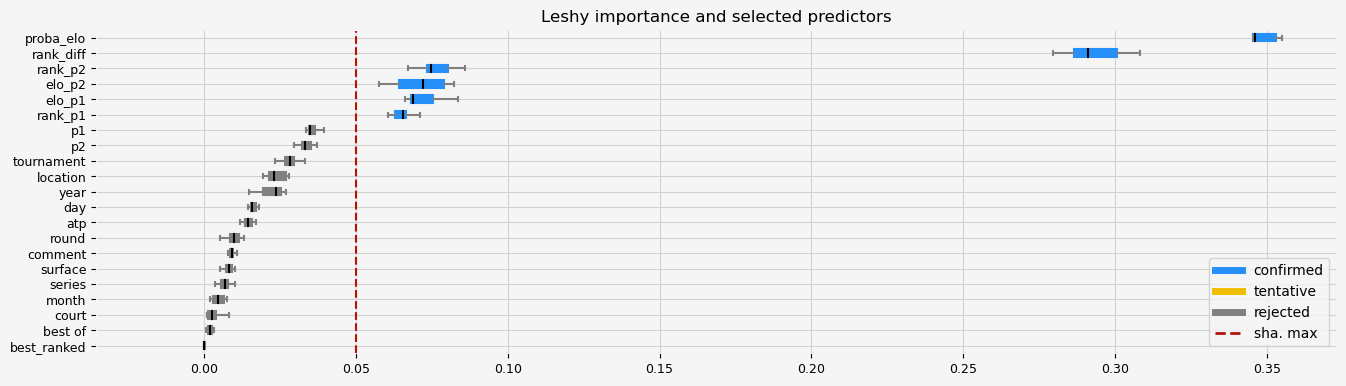

In [52]:
fig = fs_model.named_steps["fs"]["arfs"].plot_importance()

In [53]:
import optuna.integration.lightgbm as optlgb
import numpy as np
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import early_stopping
from lightgbm import log_evaluation
from pathlib import Path
from joblib import dump


def prepare_data_for_training_clf(start_date, end_date):
    """
    Prepare the ATP data for modeling.

    Parameters
    ----------
    start_date : str
        The start date of the time window.
    end_date : str
        The end date of the time window.

    Returns
    -------
    df : pandas.DataFrame
        The prepared data.

    """
    data_path = "/home/bsatom/Documents/mlops/AceBet/data/atp_data_production.feather"  # Path(__file__).resolve().parents[2] / 'data' / 'atp_data_production.feather'
    df = pd.read_feather(data_path)
    df["date"] = pd.to_datetime(df["date"])
    df = df.query("date >= @start_date and date <= @end_date")

    # Create predictors list
    predictors = df.columns.drop(
        ["target", "date", "sets_p1", "sets_p2", "b365_p1", "b365_p2", "ps_p1", "ps_p2"]
    )
    X = df[predictors].copy()
    y = df["target"].values.copy() * 1

    return X, y


def time_series_split(X, y, n_splits=2):
    """
    Split the data into training and test sets using a TimeSeriesSplit object.

    Parameters
    ----------
    X : pandas.DataFrame
        The features.
    y : pandas.Series
        The target.
    n_splits : int, default=2
        The number of splits.

    Returns
    -------
    train_idx : list
        The training indices.
    test_idx : list
        The test indices.

    """

    ts_split = TimeSeriesSplit(n_splits=n_splits)
    all_splits = list(ts_split.split(X, y))

    train_idx, test_idx = all_splits[0]
    return train_idx, test_idx


start_date = "2015-03-04"
end_date = "2017-03-04"


def train_model(start_date, end_date):
    X, y = prepare_data_for_training_clf(start_date, end_date)
    train_idx, val_idx = time_series_split(X, y, n_splits=2)
    X_train, y_train = X.iloc[train_idx, :].copy(), y[train_idx].copy()
    X_val, y_val = X.iloc[val_idx, :].copy(), y[val_idx].copy()

    encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=np.nan
    ).set_output(transform="pandas")
    encoder.fit(X_train)
    X_train_trans = encoder.transform(X_train)
    X_val_trans = encoder.transform(X_val)

    dtrain = optlgb.Dataset(X_train_trans, label=y_train)
    dval = optlgb.Dataset(X_val_trans, label=y_val)
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }
    model = optlgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        callbacks=[early_stopping(100), log_evaluation(-1)],
    )

    y_pred = np.rint(model.predict(X_val_trans, num_iteration=model.best_iteration))
    target_names = ["winner", "loser"]
    print(classification_report(y_val, y_pred, target_names=target_names))

    best_params = model.params
    print("Best params:", best_params)
    print("  Params: ")
    for key, value in best_params.items():
        print("    {}: {}".format(key, value))


if __name__ == "__main__":
    start_date = "2015-03-04"
    end_date = "2017-03-04"
    train_model(start_date, end_date)

[I 2023-08-14 15:38:58,781] A new study created in memory with name: no-name-3086dd89-f7ae-4004-8ddb-2f1cceda8e28
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.696305:  14%|#4        | 1/7 [00:01<00:07,  1.24s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.667823	valid_1's binary_logloss: 0.696305


feature_fraction, val_score: 0.684393:  29%|##8       | 2/7 [00:01<00:04,  1.06it/s]

Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.596095	valid_1's binary_logloss: 0.684393


feature_fraction, val_score: 0.684393:  43%|####2     | 3/7 [00:05<00:08,  2.01s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.596095	valid_1's binary_logloss: 0.684393


feature_fraction, val_score: 0.640070:  57%|#####7    | 4/7 [00:06<00:04,  1.56s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.532133	valid_1's binary_logloss: 0.64007


feature_fraction, val_score: 0.640070:  71%|#######1  | 5/7 [00:10<00:05,  2.70s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.532133	valid_1's binary_logloss: 0.64007


feature_fraction, val_score: 0.640070:  86%|########5 | 6/7 [00:11<00:02,  2.09s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.532133	valid_1's binary_logloss: 0.64007


feature_fraction, val_score: 0.640070: 100%|##########| 7/7 [00:13<00:00,  1.92s/it]


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.532133	valid_1's binary_logloss: 0.64007


num_leaves, val_score: 0.640070:   5%|5         | 1/20 [00:00<00:14,  1.34it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.532133	valid_1's binary_logloss: 0.64007


num_leaves, val_score: 0.640070:  10%|#         | 2/20 [00:01<00:11,  1.50it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.532133	valid_1's binary_logloss: 0.64007


num_leaves, val_score: 0.640070:  15%|#5        | 3/20 [00:02<00:14,  1.20it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.532133	valid_1's binary_logloss: 0.64007
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856


num_leaves, val_score: 0.636856:  25%|##5       | 5/20 [00:02<00:06,  2.44it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856


num_leaves, val_score: 0.636856:  30%|###       | 6/20 [00:03<00:07,  1.99it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856


num_leaves, val_score: 0.636856:  40%|####      | 8/20 [00:09<00:25,  2.12s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856


num_leaves, val_score: 0.636856:  45%|####5     | 9/20 [00:18<00:48,  4.40s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856


num_leaves, val_score: 0.636856:  50%|#####     | 10/20 [00:20<00:34,  3.49s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856


num_leaves, val_score: 0.636856:  55%|#####5    | 11/20 [00:20<00:23,  2.57s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856


num_leaves, val_score: 0.636856:  60%|######    | 12/20 [00:20<00:14,  1.85s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856


num_leaves, val_score: 0.636856:  65%|######5   | 13/20 [00:21<00:10,  1.47s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856


num_leaves, val_score: 0.636856:  70%|#######   | 14/20 [00:21<00:06,  1.13s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856


num_leaves, val_score: 0.636856:  80%|########  | 16/20 [00:22<00:02,  1.48it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856


num_leaves, val_score: 0.636856:  85%|########5 | 17/20 [00:22<00:01,  1.84it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856


num_leaves, val_score: 0.636856:  90%|######### | 18/20 [00:23<00:00,  2.04it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856


num_leaves, val_score: 0.636856:  95%|#########5| 19/20 [00:24<00:00,  1.11it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856


num_leaves, val_score: 0.636856: 100%|##########| 20/20 [00:25<00:00,  1.27s/it]


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609129	valid_1's binary_logloss: 0.636856


bagging, val_score: 0.635816:  20%|##        | 2/10 [00:00<00:01,  5.05it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609881	valid_1's binary_logloss: 0.636761
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609829	valid_1's binary_logloss: 0.635816


bagging, val_score: 0.634641:  50%|#####     | 5/10 [00:00<00:00,  7.72it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609829	valid_1's binary_logloss: 0.635816
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609829	valid_1's binary_logloss: 0.635816
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


bagging, val_score: 0.634641:  60%|######    | 6/10 [00:00<00:00,  8.60it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


bagging, val_score: 0.634641:  70%|#######   | 7/10 [00:01<00:00,  3.63it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


bagging, val_score: 0.634641:  80%|########  | 8/10 [00:04<00:01,  1.06it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


bagging, val_score: 0.634641:  90%|######### | 9/10 [00:06<00:01,  1.24s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


bagging, val_score: 0.634641: 100%|##########| 10/10 [00:12<00:00,  1.27s/it]


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


feature_fraction_stage2, val_score: 0.634641:  33%|###3      | 1/3 [00:02<00:04,  2.20s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


feature_fraction_stage2, val_score: 0.634641:  67%|######6   | 2/3 [00:04<00:02,  2.12s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


feature_fraction_stage2, val_score: 0.634641: 100%|##########| 3/3 [00:05<00:00,  1.77s/it]


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


regularization_factors, val_score: 0.634641:   5%|5         | 1/20 [00:00<00:01,  9.56it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


regularization_factors, val_score: 0.634641:  15%|#5        | 3/20 [00:00<00:01, 10.75it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


regularization_factors, val_score: 0.634641:  20%|##        | 4/20 [00:01<00:01, 10.75it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


regularization_factors, val_score: 0.634641:  25%|##5       | 5/20 [00:01<00:06,  2.34it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


regularization_factors, val_score: 0.634641:  35%|###5      | 7/20 [00:02<00:04,  2.88it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


regularization_factors, val_score: 0.634641:  40%|####      | 8/20 [00:02<00:04,  2.88it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


regularization_factors, val_score: 0.634641:  55%|#####5    | 11/20 [00:02<00:01,  4.92it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


regularization_factors, val_score: 0.634641:  65%|######5   | 13/20 [00:03<00:01,  5.69it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


regularization_factors, val_score: 0.634641:  80%|########  | 16/20 [00:03<00:00,  6.38it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


regularization_factors, val_score: 0.634641:  85%|########5 | 17/20 [00:03<00:00,  6.89it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


regularization_factors, val_score: 0.634641:  90%|######### | 18/20 [00:03<00:00,  5.88it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


regularization_factors, val_score: 0.634641:  95%|#########5| 19/20 [00:05<00:00,  2.30it/s]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


regularization_factors, val_score: 0.634641: 100%|##########| 20/20 [00:06<00:00,  3.27it/s]


Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


min_data_in_leaf, val_score: 0.634641:  20%|##        | 1/5 [00:01<00:04,  1.00s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


min_data_in_leaf, val_score: 0.634641:  40%|####      | 2/5 [00:06<00:10,  3.66s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


min_data_in_leaf, val_score: 0.634641:  80%|########  | 4/5 [00:06<00:01,  1.34s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641


min_data_in_leaf, val_score: 0.634641: 100%|##########| 5/5 [00:07<00:00,  1.41s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.609568	valid_1's binary_logloss: 0.634641
              precision    recall  f1-score   support

      winner       0.66      0.68      0.67       875
       loser       0.67      0.65      0.66       876

    accuracy                           0.67      1751
   macro avg       0.67      0.67      0.67      1751
weighted avg       0.67      0.67      0.67      1751

Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 4, 'feature_fraction': 0.4, 'bagging_fraction': 0.7957346694832138, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': None}
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 4
    feature_fraction: 0

In [54]:
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]
)
confusion_matrix

Predicted,0,1
Actual,,
0,6228,1223
1,4750,2701


I removed the HPO section (it doesn't improve much and is AZ propreitary)

# Conclusion

Let's just keep the vanilla LightGBMClassifer, fast, accurate, simple, doesn't overfit.